## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.2]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 44/50
50000/50000 [==============================] - 1s 29us/step - loss: 0.8166 - accuracy: 0.7370 - val_loss: 1.4679 - val_accuracy: 0.5034
Epoch 45/50
50000/50000 [==============================] - 1s 30us/step - loss: 0.8155 - accuracy: 0.7374 - val_loss: 1.4689 - val_accuracy: 0.5028
Epoch 46/50
50000/50000 [==============================] - 1s 30us/step - loss: 0.8138 - accuracy: 0.7388 - val_loss: 1.4692 - val_accuracy: 0.5009

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 47/50
50000/50000 [==============================] - 2s 30us/step - loss: 0.8126 - accuracy: 0.7390 - val_loss: 1.4695 - val_accuracy: 0.5023
Epoch 48/50
50000/50000 [==============================] - 1s 29us/step - loss: 0.8097 - accuracy: 0.7398 - val_loss: 1.4694 - val_accuracy: 0.5012
Epoch 49/50
50000/50000 [==============================] - 1s 30us/step - loss: 0.8105 - accuracy: 0.7400 - val_loss: 1.4708 - val_accuracy: 0.5032
Epoch 50/50
50000/50000 [======

50000/50000 [==============================] - 1s 29us/step - loss: 1.6860 - accuracy: 0.4105 - val_loss: 1.7657 - val_accuracy: 0.3817
Epoch 39/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6808 - accuracy: 0.4126 - val_loss: 1.7614 - val_accuracy: 0.3834
Epoch 40/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6752 - accuracy: 0.4134 - val_loss: 1.7567 - val_accuracy: 0.3860
Epoch 41/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6703 - accuracy: 0.4153 - val_loss: 1.7534 - val_accuracy: 0.3854
Epoch 42/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6654 - accuracy: 0.4162 - val_loss: 1.7494 - val_accuracy: 0.3872
Epoch 43/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6604 - accuracy: 0.4191 - val_loss: 1.7462 - val_accuracy: 0.3882
Epoch 44/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6550 - accuracy: 0.4203 - val_loss: 1.7418

50000/50000 [==============================] - 1s 28us/step - loss: 1.7094 - accuracy: 0.4051 - val_loss: 1.7908 - val_accuracy: 0.3778
Epoch 34/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.7024 - accuracy: 0.4069 - val_loss: 1.7861 - val_accuracy: 0.3788
Epoch 35/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6960 - accuracy: 0.4102 - val_loss: 1.7806 - val_accuracy: 0.3807
Epoch 36/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6897 - accuracy: 0.4115 - val_loss: 1.7767 - val_accuracy: 0.3814
Epoch 37/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6839 - accuracy: 0.4135 - val_loss: 1.7718 - val_accuracy: 0.3844
Epoch 38/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6790 - accuracy: 0.4153 - val_loss: 1.7668 - val_accuracy: 0.3870
Epoch 39/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6718 - accuracy: 0.4183 - val_loss: 1.7629

50000/50000 [==============================] - 1s 29us/step - loss: 1.7562 - accuracy: 0.3929 - val_loss: 1.8177 - val_accuracy: 0.3757
Epoch 29/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7483 - accuracy: 0.3948 - val_loss: 1.8113 - val_accuracy: 0.3784
Epoch 30/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7401 - accuracy: 0.3980 - val_loss: 1.8049 - val_accuracy: 0.3788
Epoch 31/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7328 - accuracy: 0.4012 - val_loss: 1.7998 - val_accuracy: 0.3816
Epoch 32/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7254 - accuracy: 0.4019 - val_loss: 1.7939 - val_accuracy: 0.3843
Epoch 33/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7185 - accuracy: 0.4037 - val_loss: 1.7890 - val_accuracy: 0.3853
Epoch 34/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.7118 - accuracy: 0.4050 - val_loss: 1.7838

50000/50000 [==============================] - 2s 30us/step - loss: 0.4651 - accuracy: 0.8610 - val_loss: 1.5984 - val_accuracy: 0.5181
Epoch 23/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.4413 - accuracy: 0.8695 - val_loss: 1.6093 - val_accuracy: 0.5055
Epoch 24/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.4204 - accuracy: 0.8783 - val_loss: 1.6618 - val_accuracy: 0.5055

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.3724 - accuracy: 0.9012 - val_loss: 1.5673 - val_accuracy: 0.5265
Epoch 26/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.3531 - accuracy: 0.9082 - val_loss: 1.5785 - val_accuracy: 0.5241
Epoch 27/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.3443 - accuracy: 0.9130 - val_loss: 1.6188 - val_accuracy: 0.5187
Epoch 28/50
50000/50000 [==================

Epoch 14/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.6211 - accuracy: 0.4368 - val_loss: 1.7147 - val_accuracy: 0.4046
Epoch 15/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6090 - accuracy: 0.4415 - val_loss: 1.7078 - val_accuracy: 0.4054
Epoch 16/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.5972 - accuracy: 0.4453 - val_loss: 1.7048 - val_accuracy: 0.4087
Epoch 17/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.5866 - accuracy: 0.4478 - val_loss: 1.6972 - val_accuracy: 0.4103
Epoch 18/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.5767 - accuracy: 0.4529 - val_loss: 1.6915 - val_accuracy: 0.4149
Epoch 19/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.5670 - accuracy: 0.4558 - val_loss: 1.6878 - val_accuracy: 0.4140
Epoch 20/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.5576 - accuracy: 0.4593 - val_

50000/50000 [==============================] - 2s 30us/step - loss: 1.6746 - accuracy: 0.4192 - val_loss: 1.7293 - val_accuracy: 0.3926
Epoch 10/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6562 - accuracy: 0.4257 - val_loss: 1.7169 - val_accuracy: 0.3987
Epoch 11/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6396 - accuracy: 0.4305 - val_loss: 1.7116 - val_accuracy: 0.4020
Epoch 12/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6234 - accuracy: 0.4374 - val_loss: 1.7021 - val_accuracy: 0.4079
Epoch 13/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6094 - accuracy: 0.4405 - val_loss: 1.6978 - val_accuracy: 0.4114
Epoch 14/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.5975 - accuracy: 0.4450 - val_loss: 1.6913 - val_accuracy: 0.4121
Epoch 15/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.5841 - accuracy: 0.4508 - val_loss: 1.6876

50000/50000 [==============================] - 1s 30us/step - loss: 1.8079 - accuracy: 0.3757 - val_loss: 1.9096 - val_accuracy: 0.3071
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.7641 - accuracy: 0.3902 - val_loss: 1.8390 - val_accuracy: 0.3418
Epoch 6/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.7307 - accuracy: 0.4017 - val_loss: 1.7930 - val_accuracy: 0.3650
Epoch 7/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.7026 - accuracy: 0.4108 - val_loss: 1.7631 - val_accuracy: 0.3785
Epoch 8/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.6800 - accuracy: 0.4177 - val_loss: 1.7434 - val_accuracy: 0.3872
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6591 - accuracy: 0.4247 - val_loss: 1.7282 - val_accuracy: 0.3951
Epoch 10/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6413 - accuracy: 0.4308 - val_loss: 1.7159 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.8088 - accuracy: 0.3707 - val_loss: 2.6494 - val_accuracy: 0.2092
Epoch 2/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.5330 - accuracy: 0.4576 - val_loss: 2.1649 - val_accuracy: 0.2730
Epoch 3/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.4317 - accuracy: 0.4938 - val_loss: 1.7513 - val_accuracy: 0.3700
Epoch 4/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.3544 - accuracy: 0.5207 - val_loss: 1.8871 - val_accuracy: 0.3330
Epoch 5/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.2951 - accuracy: 0.5441 - val_loss: 1.7919 - val_accuracy: 0.3791
Epoch 6/50
50000/50000 [==============================] - 1s 30us/step - loss: 1.2406 - accuracy: 0.5632 - val_loss: 2.2439 - val_accuracy: 0.3140
Epoch 7/50
50000/50000 [==============================] - 1s 29us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.6538 - accuracy: 0.1600 - val_loss: 2.2976 - val_accuracy: 0.1296
Epoch 2/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.3738 - accuracy: 0.2179 - val_loss: 2.1924 - val_accuracy: 0.1989
Epoch 3/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.2202 - accuracy: 0.2554 - val_loss: 2.1172 - val_accuracy: 0.2444
Epoch 4/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.1174 - accuracy: 0.2814 - val_loss: 2.0548 - val_accuracy: 0.2722
Epoch 5/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.0423 - accuracy: 0.3050 - val_loss: 1.9973 - val_accuracy: 0.2955
Epoch 6/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.9852 - accuracy: 0.3198 - val_loss: 1.9526 - val_accuracy: 0.3140
Epoch 7/50
50000/50000 [==============================] - 2s 30us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.7597 - accuracy: 0.1339 - val_loss: 2.2797 - val_accuracy: 0.1247
Epoch 2/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.4766 - accuracy: 0.1935 - val_loss: 2.2358 - val_accuracy: 0.1611
Epoch 3/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.3098 - accuracy: 0.2356 - val_loss: 2.1836 - val_accuracy: 0.2022
Epoch 4/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.1991 - accuracy: 0.2633 - val_loss: 2.1151 - val_accuracy: 0.2425
Epoch 5/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.1164 - accuracy: 0.2852 - val_loss: 2.0508 - val_accuracy: 0.2755
Epoch 6/50
50000/50000 [==============================] - 2s 30us/step - loss: 2.0511 - accuracy: 0.3018 - val_loss: 1.9954 - val_accuracy: 0.2961
Epoch 7/50
50000/50000 [==============================] - 2s 30us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.7227 - accuracy: 0.1429 - val_loss: 2.3025 - val_accuracy: 0.1476
Epoch 2/50
50000/50000 [==============================] - 1s 29us/step - loss: 2.4488 - accuracy: 0.2026 - val_loss: 2.2251 - val_accuracy: 0.1876
Epoch 3/50
50000/50000 [==============================] - 1s 29us/step - loss: 2.2927 - accuracy: 0.2417 - val_loss: 2.1541 - val_accuracy: 0.2273
Epoch 4/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.1876 - accuracy: 0.2690 - val_loss: 2.0854 - val_accuracy: 0.2600
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.1106 - accuracy: 0.2878 - val_loss: 2.0272 - val_accuracy: 0.2846
Epoch 6/50
50000/50000 [==============================] - 1s 30us/step - loss: 2.0489 - accuracy: 0.3050 - val_loss: 1.9807 - val_accuracy: 0.3031
Epoch 7/50
50000/50000 [==============================] - 1s 29us/st

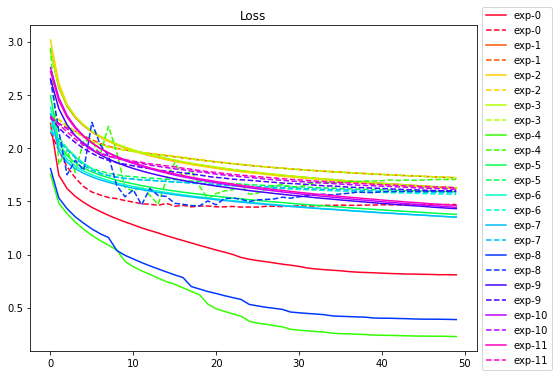

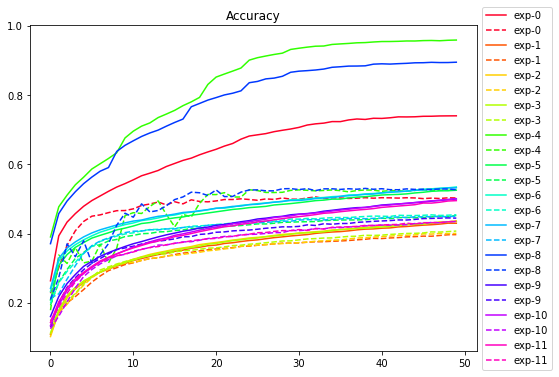

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print(f'EXP: {i}, optimizer: {optim}, factor: {reduce_factor}, patient: {reduce_patient}')

EXP: 0, optimizer: <keras.optimizers.SGD object at 0x000002FA5D346EC8>, factor: 0.5, patient: 5
EXP: 1, optimizer: <keras.optimizers.SGD object at 0x000002FA5D346EC8>, factor: 0.5, patient: 10
EXP: 2, optimizer: <keras.optimizers.SGD object at 0x000002FA5D346EC8>, factor: 0.2, patient: 5
EXP: 3, optimizer: <keras.optimizers.SGD object at 0x000002FA5D346EC8>, factor: 0.2, patient: 10
EXP: 4, optimizer: <keras.optimizers.Adam object at 0x000002FA5D346D88>, factor: 0.5, patient: 5
EXP: 5, optimizer: <keras.optimizers.Adam object at 0x000002FA5D346D88>, factor: 0.5, patient: 10
EXP: 6, optimizer: <keras.optimizers.Adam object at 0x000002FA5D346D88>, factor: 0.2, patient: 5
EXP: 7, optimizer: <keras.optimizers.Adam object at 0x000002FA5D346D88>, factor: 0.2, patient: 10
EXP: 8, optimizer: <keras.optimizers.RMSprop object at 0x000002FA5D346DC8>, factor: 0.5, patient: 5
EXP: 9, optimizer: <keras.optimizers.RMSprop object at 0x000002FA5D346DC8>, factor: 0.5, patient: 10
EXP: 10, optimizer: <ke